# Intro

## Standard modules

In [1]:
import os, sys, pickle
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.metrics import v_measure_score

In [8]:
import seaborn as sns

In [9]:
import pymannkendall as mk

In [10]:
from scipy.spatial.distance import cosine

In [365]:
from scipy.stats import ks_2samp

In [11]:
import requests
import re
from bs4 import BeautifulSoup  # Per pulizia HTML nelle REST API

In [12]:
import datetime as dt

In [280]:
from scipy.stats import spearmanr

## Personal modules

In [13]:
from toolbox.updater import time_is_now

In [14]:
from file2text import file2text

In [15]:
from first_rough_cleaning import first_text_cleaner

In [16]:
from file_handler import *

In [17]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [18]:
from tabulate import tabulate

## Folders

In [19]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [20]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [21]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/abtt5_vectors/'

In [272]:
TEXT_FOLDER='./NewProcessedData/texts/'

## Sector helper

In [22]:
rtf_files=os.listdir('./rtf')
rtf_files.sort()

In [23]:
sec_helper={}
for file in rtf_files:
    splitted_name=file.split('_')
    if splitted_name[0].isnumeric():
        if splitted_name[0] not in sec_helper.keys():
            sec_helper[splitted_name[0].zfill(2)]=splitted_name[1]

In [24]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

### Aggregated sectors

In [25]:
agg_secs={'A': {'name':'Consumer Goods', 'sectors':['02', '03']}, 
 'B':{'name':'Essential Infrastructure & Services', 'sectors':['08', '10', '11']}, 
 'C':{'name':'Production Sectors','sectors':['01', '04', '07']},
 'D':{'name':'Specialized Services','sectors':['05', '06', '09']}}

In [26]:
sec2agg_d={'01':'C', '02':'A', '03':'A', '04':'C', '05':'D', '06':'D', '07':'C', '08':'B', '09':'D', '10':'B', '11':'B'}

## SDG helper

In [27]:
sdg_helper={'01':'No Poverty', 
 '02': 'Zero hunger', 
 '03': 'Good health and well-being', 
 '04': 'Quality education',
 '05': 'Gender equality',
 '06': 'Clean water and sanitation',
 '07': 'Affordable and clean energy',
 '08': 'Decent work and economic growth',
 '09': 'Industry, Innovation, Technology and Infrastructure',
 '10': 'Reduced inequality',
 '11': 'Sustainable cities and communities',
 '12': 'Responsible consumption and production',
 '13': 'Climate action',
 '14': 'Life below water',
 '15': 'Life on land',
 '16': 'Peace, justice and strong institutions',
 '17': 'Partnerships for the goals'
}

## Load vectors

In [28]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [29]:
vecfiles.sort()

### Reports' vectors

In [30]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [31]:
reports_files.sort()

In [32]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [33]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [34]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [35]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

### Reports aggregated per sector per year

For each and sector I have an only entry, therefore the final vector has 

In [36]:
_tracks=np.unique(vectors[['year', 'sector']])
l_aggr_rep=len(_tracks)
l_aggr_rep

96

entries.

In [37]:
aggr_vectors=np.zeros(l_aggr_rep, dtype=[('year', 'i4'), ('sector', 'U2'), ('vector', object)])

In [38]:
for i_t, _track in enumerate(tqdm(_tracks)):
    year=_track[0]
    sector=_track[1]
    # select entries in vectors
    _mask=np.logical_and(vectors['year']==year, vectors['sector']==sector)
    _selection=vectors[_mask]
    # define te entries in aggr_vectors
    aggr_vectors[i_t]['year']=year
    aggr_vectors[i_t]['sector']=sector
    aggr_vectors[i_t]['vector']=np.mean(_selection['vector'])

  0%|          | 0/96 [00:00<?, ?it/s]

### Reports aggregated per aggregated sector per year

For each and sector I have an only entry, therefore the final vector has 

In [39]:
l_aggr_aggsec=4*len(years)
l_aggr_aggsec

36

entries.

In [40]:
aggsec_aggr_vectors=np.zeros(l_aggr_aggsec, dtype=[('year', 'i4'), ('agg_sec', 'U2'), ('vector', object)])

In [41]:
index=0
for year in tqdm(years):
    for i in range(4):
        _agg=chr(i+ord('A'))
        _agg_sectors=agg_secs[_agg]['sectors']
        # select entries in vectors
        _mask=np.logical_and(vectors['year']==year, np.isin(vectors['sector'],_agg_sectors))
        _selection=vectors[_mask]
        # define the entries in aggr_vectors
        aggsec_aggr_vectors[index]['year']=year
        aggsec_aggr_vectors[index]['agg_sec']=_agg
        aggsec_aggr_vectors[index]['vector']=np.mean(_selection['vector'])
        index+=1

  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_23862/503975990.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  _mask=np.logical_and(vectors['year']==year, np.isin(vectors['sector'],_agg_sectors))
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


### Witten's vector

In [42]:
wittenvecfile=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [43]:
wittenvec=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+wittenvecfile)

### Goals' vectors

In [44]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [45]:
goalvecfiles.sort()

In [46]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [47]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Wikipedia's vectors

In [48]:
wikivecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('wiki')]

In [49]:
wikivecfiles.sort()

In [50]:
len(wikivecfiles)

4001

In [51]:
wikivecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+wikivecfile) for wikivecfile in wikivecfiles]

## FDR

In [52]:
def fdr_th(p_vals, alpha):
    _aux=np.sort(p_vals)
    fdr_ths=np.arange(1, 1+len(_aux))*alpha/len(_aux)
    fdr_mask=_aux<=fdr_ths
    if np.sum(fdr_mask)>0:
        return fdr_ths[fdr_mask][-1]
    else:
        return 0.

# The benchmark

In [49]:
years=years.astype('i4')

## Creating the benchmark, at the firm level _[DO NOT EVALUATE IT AGAIN!!!]_

In [48]:
wiki_bench=np.zeros(len(vectors), dtype=[('cos_sim', object)])

In [49]:
for i_v in trange(len(vectors)):
    wiki_bench[i_v]['cos_sim']=np.zeros(len(wikivecs))
    for i_w, wikivec in enumerate(tqdm(wikivecs, leave=False)):
        wiki_bench[i_v]['cos_sim'][i_w]=float(util.cos_sim(wikivec, vectors[i_v]['vector']))

  0%|          | 0/573 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

In [51]:
with open('./NewProcessedData/wiki_benchmark.pickle', 'wb') as f:
    pickle.dump(wiki_bench, f)

## Creating the benchmark, at the sector level _[DO NOT EVALUATE IT AGAIN!!!]_

In [130]:
wiki_bench_per_sector=np.zeros(l_aggr_rep, dtype=[('cos_sim', object)])

In [131]:
for i_v in trange(l_aggr_rep):
    wiki_bench_per_sector[i_v]['cos_sim']=np.zeros(len(wikivecs))
    for i_w, wikivec in enumerate(tqdm(wikivecs, leave=False)):
        wiki_bench_per_sector[i_v]['cos_sim'][i_w]=float(util.cos_sim(wikivec, aggr_vectors[i_v]['vector']))

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

In [132]:
with open('./NewProcessedData/wiki_bench_per_sector.pickle', 'wb') as f:
    pickle.dump(wiki_bench_per_sector, f)

## Creating the benchmark, at the aggregated sector level _[DO NOT EVALUATE IT AGAIN!!!]_

In [100]:
wiki_bench_per_agg_sec=np.zeros(l_aggr_aggsec, dtype=[('cos_sim', object)])

In [101]:
for i_v in trange(l_aggr_aggsec):
    wiki_bench_per_agg_sec[i_v]['cos_sim']=np.zeros(len(wikivecs))
    for i_w, wikivec in enumerate(tqdm(wikivecs, leave=False)):
        wiki_bench_per_agg_sec[i_v]['cos_sim'][i_w]=float(util.cos_sim(wikivec, aggsec_aggr_vectors[i_v]['vector']))

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

In [102]:
with open('./NewProcessedData/wiki_bench_per_agg_sector.pickle', 'wb') as f:
    pickle.dump(wiki_bench_per_agg_sec, f)

# Validation

In [226]:
alpha=0.05

## All SDGs

In [220]:
with open('./NewProcessedData/wiki_benchmark_abtt5.pickle', 'rb') as f:
    wiki_bench=pickle.load(f)

In [221]:
cos_sims_global=np.zeros(len(years), dtype=[('mean', 'f8'), ('all', object), ('p_val', object)])

In [222]:
for i_y, year in enumerate(tqdm(years)):
    vecs_y=vectors[vectors['year']==year]['vector']
    wiki_bench_y=wiki_bench[vectors['year']==year]['cos_sim']
    cos_sims_global[i_y]['all']=np.zeros(len(vecs_y))
    cos_sims_global[i_y]['p_val']=np.zeros(len(vecs_y))
    for i_vec, vec in enumerate(tqdm(vecs_y, leave=False)):
        _cos_sim=float(util.cos_sim(goalvecs[-1], vec))
        cos_sims_global[i_y]['all'][i_vec]=_cos_sim
        cos_sims_global[i_y]['p_val'][i_vec]=np.sum(wiki_bench_y[i_vec]>=_cos_sim)/len(wikivecs)
    cos_sims_global[i_y]['mean']=np.mean(cos_sims_global[i_y]['all'])

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [250]:
for i_y, year in enumerate(tqdm(years)):
    _fdr_th=fdr_th(cos_sims_global[i_y]['p_val'], alpha)
    print(f'{year:}) len(validated_companies)={len(validated_compa):}, FDR={_fdr_th:.2e}')
    #_fdr_th=1
    compa_y=vectors[vectors['year']==year]['company']
    sec_y=vectors[vectors['year']==year]['sector']
    validated_compa=compa_y[cos_sims_global[i_y]['p_val']<=_fdr_th]
    validated_sec=sec_y[cos_sims_global[i_y]['p_val']<=_fdr_th]
    validated_p=cos_sims_global[i_y]['p_val'][cos_sims_global[i_y]['p_val']<=_fdr_th]
    
    if len(validated_compa)>0:
        for i_vc, vc in enumerate(validated_compa):
            print(f'\t\t{vc:25} sector={sec_helper[validated_sec[i_vc]]:}, p-value={validated_p[i_vc]:.2e}')

  0%|          | 0/9 [00:00<?, ?it/s]

2015) len(validated_companies)=40, FDR=5.00e-03
		unilever                  sector=Consumer Staples, p-value=1.00e-03
		standard_chartered        sector=Financials, p-value=4.00e-03
		halma                     sector=Industrials, p-value=5.00e-04
		land_securities_group     sector=Real Estate, p-value=2.50e-04
2016) len(validated_companies)=4, FDR=3.41e-03
		unilever                  sector=Consumer Staples, p-value=1.00e-03
		standard_chartered        sector=Financials, p-value=5.00e-04
		halma                     sector=Industrials, p-value=0.00e+00
2017) len(validated_companies)=3, FDR=9.80e-04
		halma                     sector=Industrials, p-value=0.00e+00
2018) len(validated_companies)=1, FDR=1.79e-03
		standard_chartered        sector=Financials, p-value=1.25e-03
		halma                     sector=Industrials, p-value=1.50e-03
2019) len(validated_companies)=2, FDR=0.00e+00
2020) len(validated_companies)=0, FDR=2.90e-03
		anglo_american            sector=Basic Materials, p-value=

### Consistency checks

Unilever

In [244]:
len(cos_sims_global[i_y]['p_val'])

40

In [246]:
vectors.dtype

dtype([('year', '<i4'), ('sector', '<U2'), ('company', '<U100'), ('vector', 'O')])

In [256]:
p_val_uni=np.zeros(len(years))
val_uni=np.zeros(len(years), dtype=bool)
fdrs=np.zeros(len(years))
for i_y, year in enumerate(tqdm(years)):
    _fdr_th=fdr_th(cos_sims_global[i_y]['p_val'], alpha)
    fdrs[i_y]=_fdr_th
    where_uni=vectors[vectors['year']==year]
    where_uni=np.where(where_uni['company']=='unilever')[0][0]
    p_val=cos_sims_global[i_y]['p_val'][where_uni]
    p_val_uni[i_y]=p_val
    val_uni[i_y]=p_val<=_fdr_th

  0%|          | 0/9 [00:00<?, ?it/s]

In [257]:
np.vstack((p_val_uni, val_uni, fdrs, years)).T

array([[9.99750062e-04, 1.00000000e+00, 5.00000000e-03, 2.01500000e+03],
       [9.99750062e-04, 1.00000000e+00, 3.40909091e-03, 2.01600000e+03],
       [9.32266933e-02, 0.00000000e+00, 9.80392157e-04, 2.01700000e+03],
       [6.61584604e-01, 0.00000000e+00, 1.78571429e-03, 2.01800000e+03],
       [6.23094226e-01, 0.00000000e+00, 0.00000000e+00, 2.01900000e+03],
       [1.47213197e-01, 0.00000000e+00, 2.89855072e-03, 2.02000000e+03],
       [4.40389903e-01, 0.00000000e+00, 1.31578947e-03, 2.02100000e+03],
       [1.39215196e-01, 0.00000000e+00, 1.87500000e-03, 2.02200000e+03],
       [1.14721320e-01, 0.00000000e+00, 5.55555556e-04, 2.02300000e+03]])

### Table for $\LaTeX$

In [97]:
_table=[]
for i_y, year in enumerate(tqdm(years)):
    _fdr_th=fdr_th(cos_sims_global[i_y]['p_val'], alpha)
    compa_y=vectors[vectors['year']==year]['company']
    sec_y=vectors[vectors['year']==year]['sector']
    validated_compa=compa_y[cos_sims_global[i_y]['p_val']<=_fdr_th]
    validated_sec=sec_y[cos_sims_global[i_y]['p_val']<=_fdr_th]
    print(f'{year:}) len(validated_companies)={len(validated_compa):}')
    if len(validated_compa)>0:
        for i_vc, vc in enumerate(validated_compa):
            company_name_smooth=vc.split('_')
            company_name_smooth=[_.capitalize() for _ in company_name_smooth]
            company_name_smooth=' '.join(company_name_smooth)
            if i_vc==0:
                _table.append([year, company_name_smooth, sec_helper[validated_sec[i_vc]]])
            else:
                _table.append(['', company_name_smooth, sec_helper[validated_sec[i_vc]]])
    else:
        _table.append([year, '', ''])

  0%|          | 0/9 [00:00<?, ?it/s]

2015) len(validated_companies)=4
2016) len(validated_companies)=3
2017) len(validated_companies)=1
2018) len(validated_companies)=2
2019) len(validated_companies)=0
2020) len(validated_companies)=4
2021) len(validated_companies)=2
2022) len(validated_companies)=3
2023) len(validated_companies)=1


In [98]:
header=['Year','Firm', 'Sector']

In [99]:
print(tabulate(_table, header, tablefmt="latex"))

\begin{tabular}{lll}
\hline
 Year   & Firm                  & Sector                 \\
\hline
 2015   & Unilever              & Consumer Staples       \\
        & Standard Chartered    & Financials             \\
        & Halma                 & Industrials            \\
        & Land Securities Group & Real Estate            \\
 2016   & Unilever              & Consumer Staples       \\
        & Standard Chartered    & Financials             \\
        & Halma                 & Industrials            \\
 2017   & Halma                 & Industrials            \\
 2018   & Standard Chartered    & Financials             \\
        & Halma                 & Industrials            \\
 2019   &                       &                        \\
 2020   & Anglo American        & Basic Materials        \\
        & Barratt Developments  & Consumer Discretionary \\
        & Hsbc Holdings         & Financials             \\
        & Standard Chartered    & Financials             \\
 2021

### Another check: correlation between length and cosine similarity

In [ ]:
np.concatenate([cos_sims_global[_]['all'] for _ in range(9)]) 

In [275]:
textfiles=os.listdir(TEXT_FOLDER)

textfiles.sort()

In [276]:
# files from 2024 are un reliable, 
# as they probably refer to a different accounting year,
# due to differences with other countries
len(textfiles)

575

In [277]:
textfiles=[textfile for textfile in textfiles if not textfile.startswith('2024')]

In [278]:
l_reports=np.zeros(len(textfiles))
for i_tf, textfile in enumerate(tqdm(textfiles)):
    with open(TEXT_FOLDER+textfile, 'r') as f:
        _text=f.readline()
    l_reports[i_tf]=len(_text)

  0%|          | 0/573 [00:00<?, ?it/s]

In [279]:
cos_sim_global=np.concatenate([cos_sims_global[_]['all'] for _ in range(9)])

In [281]:
spearmanr(cos_sim_global, l_reports)

SignificanceResult(statistic=0.27589318285936365, pvalue=1.8095588024960275e-11)

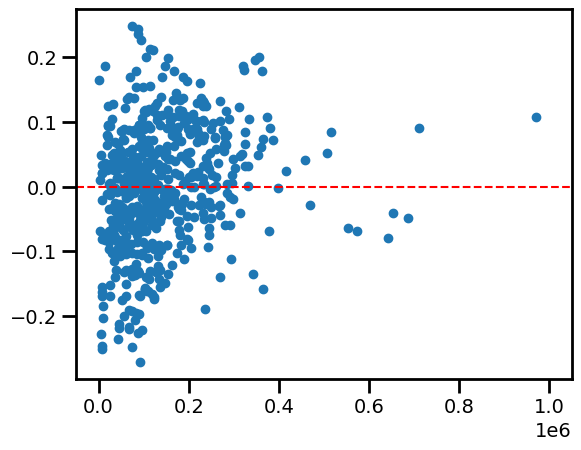

In [303]:
plt.scatter(l_reports, cos_sim_global)
plt.hlines(0, -1*10**6, 1.2*10**6, ls='--', color='r')
plt.xlim(-.05*10**6, 1.05*10**6)
plt.show()

In [297]:
bins = np.linspace(l_reports.min(), l_reports.max(), 15)

In [298]:
digitized = np.digitize(l_reports, bins)

In [299]:
variances = [cos_sim_global[digitized == i].var() for i in range(1, len(bins))]

/tmp/ipykernel_23862/3819355246.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = [cos_sim_global[digitized == i].var() for i in range(1, len(bins))]


In [327]:
len_var = np.array([len(cos_sim_global[digitized == i])/len(cos_sim_global) for i in range(1, len(bins))])

In [321]:
bin_centers = 0.5 * (bins[:-1] + bins[1:])

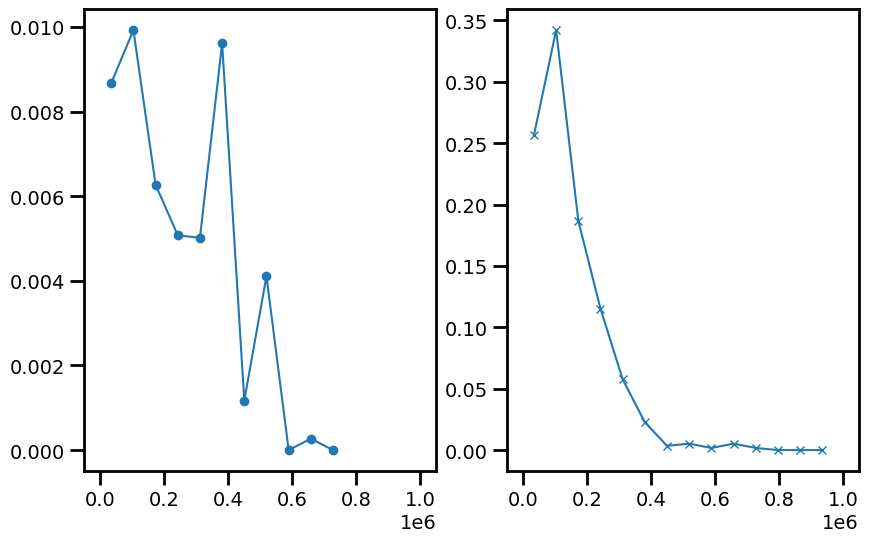

In [326]:
fig, axs=plt.subplots(1,2, figsize=(10,6))
axs[0].plot(bin_centers, variances, marker='o')
axs[0].set_xlim(-.05*10**6, 1.05*10**6)

axs[1].plot(bin_centers, len_var, marker='x')
axs[1].set_xlim(-.05*10**6, 1.05*10**6)
plt.show()

In [315]:
variances=np.array(variances)
bin_centers=np.array(bin_centers)

In [317]:
spearmanr(bin_centers[~np.isnan(variances)], variances[~np.isnan(variances)])

SignificanceResult(statistic=-0.8656058903985899, pvalue=0.0005746337965529294)

In [328]:
spearmanr(bin_centers, len_var)

SignificanceResult(statistic=-0.9624105788202938, pvalue=3.7552896196291493e-08)

In [334]:
bins

array([2.60000000e+01, 6.92737857e+04, 1.38521571e+05, 2.07769357e+05,
       2.77017143e+05, 3.46264929e+05, 4.15512714e+05, 4.84760500e+05,
       5.54008286e+05, 6.23256071e+05, 6.92503857e+05, 7.61751643e+05,
       8.30999429e+05, 9.00247214e+05, 9.69495000e+05])

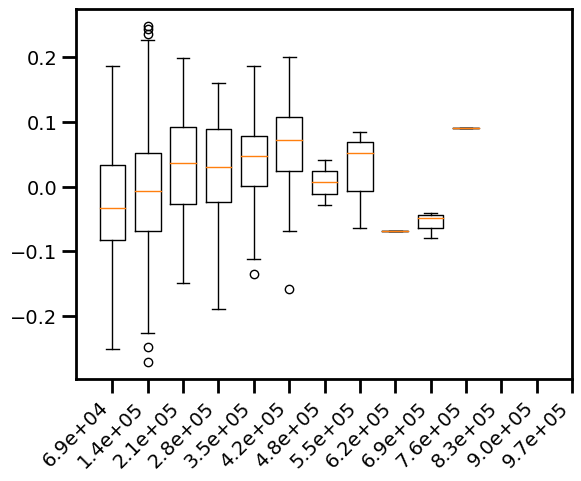

In [346]:
plt.boxplot([cos_sim_global[digitized == i] for i in range(1, len(bins))], positions=bins[1:], widths=5*10**4)
plt.xticks(bins[1:], [f'{pos:.1e}' for pos in bins[1:]],rotation=45, ha='right')
plt.show()

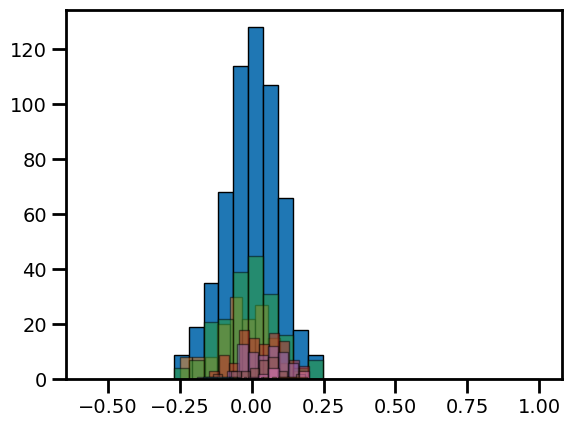

In [354]:
plt.hist(cos_sim_global, edgecolor='black')
for i in range(1, len(bins)):
    plt.hist(cos_sim_global[digitized == i], alpha=.5, edgecolor='black')
plt.show()

In [364]:
len(bins)

15

In [360]:
ks_pvals=[]
for i in range(1, len(bins)):
    sliced_distribution=cos_sim_global[digitized == i]
    if len(sliced_distribution)>0:
        stat, pval = ks_2samp(cos_sim_global, sliced_distribution)
        print(f'{i}) stat={stat:.3f}, pval={pval:.2e}')
        ks_pvals.append(pval)

1) stat=0.166, pval=2.68e-03
2) stat=0.071, pval=4.20e-01
3) stat=0.146, pval=3.72e-02
4) stat=0.196, pval=1.82e-02
5) stat=0.245, pval=3.94e-02
6) stat=0.376, pval=4.00e-02
7) stat=0.366, pval=8.93e-01
8) stat=0.360, pval=7.11e-01
9) stat=0.791, pval=4.22e-01
10) stat=0.689, pval=6.14e-02
11) stat=0.829, pval=3.45e-01


In [362]:
fdr_005_ks_pvals=fdr_th(ks_pvals, 0.05)

In [363]:
[i_p for i_p, pval in enumerate(ks_pvals) if pval<=fdr_005_ks_pvals]

[0]

## All SDGs, per sector

In [135]:
cos_sims_global_sec=np.zeros(len(years), dtype=[('all', object), ('p_val', object)])

In [136]:
with open('./NewProcessedData/wiki_bench_per_sector.pickle', 'rb') as f:
    wiki_bench_per_sector=pickle.load(f)

In [138]:
for i_y, year in enumerate(tqdm(years)):
    vecs_y=aggr_vectors[aggr_vectors['year']==year]['vector']
    wiki_bench_y=wiki_bench_per_sector[aggr_vectors['year']==year]['cos_sim']
    cos_sims_global_sec[i_y]['all']=np.zeros(len(vecs_y))
    cos_sims_global_sec[i_y]['p_val']=np.zeros(len(vecs_y))
    for i_vec, vec in enumerate(vecs_y):
        _cos_sim=float(util.cos_sim(goalvecs[-1], vec))
        cos_sims_global_sec[i_y]['all'][i_vec]=_cos_sim
        cos_sims_global_sec[i_y]['p_val'][i_vec]=np.sum(wiki_bench_y[i_vec]>=_cos_sim)/len(wikivecs)

  0%|          | 0/9 [00:00<?, ?it/s]

In [141]:
for i_y, year in enumerate(tqdm(years)):
    _fdr_th=fdr_th(cos_sims_global_sec[i_y]['p_val'], alpha)
    sec_y=aggr_vectors[aggr_vectors['year']==year]['sector']
    validated_sec=sec_y[cos_sims_global_sec[i_y]['p_val']<=_fdr_th]
    print(f'{year:}) len(validated_sectors)={len(validated_sec):}')
    if len(validated_sec)>0:
        for i_vs, vs in enumerate(validated_sec):
            print(f'\t\t{vs:25} sector={sec_helper[vs]:}')

  0%|          | 0/9 [00:00<?, ?it/s]

2015) len(validated_sectors)=0
2016) len(validated_sectors)=0
2017) len(validated_sectors)=0
2018) len(validated_sectors)=1
		05                        sector=Financials
2019) len(validated_sectors)=0
2020) len(validated_sectors)=0
2021) len(validated_sectors)=0
2022) len(validated_sectors)=1
		05                        sector=Financials
2023) len(validated_sectors)=0


## All SDGs, per aggregated sector

In [106]:
cos_sims_global_agg_sec=np.zeros(len(years), dtype=[('all', object), ('p_val', object)])

In [107]:
with open('./NewProcessedData/wiki_bench_per_agg_sector.pickle', 'rb') as f:
    wiki_bench_per_agg_sector=pickle.load(f)

In [109]:
for i_y, year in enumerate(tqdm(years)):
    vecs_y=aggsec_aggr_vectors[aggsec_aggr_vectors['year']==year]['vector']
    wiki_bench_y=wiki_bench_per_agg_sector[aggsec_aggr_vectors['year']==year]['cos_sim']
    cos_sims_global_agg_sec[i_y]['all']=np.zeros(len(vecs_y))
    cos_sims_global_agg_sec[i_y]['p_val']=np.zeros(len(vecs_y))
    for i_vec, vec in enumerate(vecs_y):
        _cos_sim=float(util.cos_sim(goalvecs[-1], vec))
        cos_sims_global_agg_sec[i_y]['all'][i_vec]=_cos_sim
        cos_sims_global_agg_sec[i_y]['p_val'][i_vec]=np.sum(wiki_bench_y[i_vec]>=_cos_sim)/len(wikivecs)

  0%|          | 0/9 [00:00<?, ?it/s]

In [110]:
for i_y, year in enumerate(tqdm(years)):
    _fdr_th=fdr_th(cos_sims_global_agg_sec[i_y]['p_val'], alpha)
    sec_y=aggsec_aggr_vectors[aggsec_aggr_vectors['year']==year]['agg_sec']
    validated_sec=sec_y[cos_sims_global_agg_sec[i_y]['p_val']<=_fdr_th]
    print(f'{year:}) len(validated_sectors)={len(validated_sec):}')
    if len(validated_sec)>0:
        for i_vs, vs in enumerate(validated_sec):
            print(f"\t\t{vs:25} sector={agg_secs[vs]['name']:}")

  0%|          | 0/9 [00:00<?, ?it/s]

2015) len(validated_sectors)=0
2016) len(validated_sectors)=0
2017) len(validated_sectors)=0
2018) len(validated_sectors)=0
2019) len(validated_sectors)=0
2020) len(validated_sectors)=3
		A                         sector=Consumer Goods
		C                         sector=Production Sectors
		D                         sector=Specialized Services
2021) len(validated_sectors)=0
2022) len(validated_sectors)=0
2023) len(validated_sectors)=0


## Clustered SDGs

### Define cSDGs

In [89]:
social_sdgs=['01','02','03','04','05','10','16','17']
economic_sdgs=['07','08','09','11','12']
environmental_sdgs=['06','13','14','15']

In [90]:
social_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in social_sdgs])]
social_vec=np.mean(social_vec, axis=0)

In [91]:
economic_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in economic_sdgs])]
economic_vec=np.mean(economic_vec, axis=0)

In [92]:
environmental_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in environmental_sdgs])]
environmental_vec=np.mean(environmental_vec, axis=0)

In [93]:
clustered_sdgs=np.array([social_vec, economic_vec, environmental_vec])

In [94]:
clustered_sdgs.shape

(3, 768)

In [95]:
cSDGS_names=['social', 'economic', 'environmental']

In [96]:
l_csdgs=len(cSDGS_names)

### All sectors

#### Cosine similarity validation

In [78]:
cos_sims_cSDGs=np.zeros(len(years)*len(cSDGS_names), dtype=[('cSDG', 'U20'), ('mean', 'f8'), ('all', object), ('p_val', object)])

In [79]:
for i_y, year in enumerate(tqdm(years)):
    vecs_y=vectors[vectors['year']==year]['vector']
    wiki_bench_y=wiki_bench[vectors['year']==year]['cos_sim']
    for i_c, csdg in enumerate(cSDGS_names):
        cos_sims_cSDGs[i_y*l_csdgs+i_c]['cSDG']=csdg
        cos_sims_cSDGs[i_y*l_csdgs+i_c]['all']=np.zeros(len(vecs_y))
        cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val']=np.zeros(len(vecs_y))
        for i_vec, vec in enumerate(vecs_y):
            _cos_sim=float(util.cos_sim(clustered_sdgs[i_c], vec))
            cos_sims_cSDGs[i_y*l_csdgs+i_c]['all'][i_vec]=_cos_sim
            cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val'][i_vec]=np.sum(wiki_bench_y[i_vec]>=_cos_sim)/len(wikivecs)
        cos_sims_cSDGs[i_y*l_csdgs+i_c]['mean']=np.mean(cos_sims_cSDGs[i_y*l_csdgs+i_c]['all'])

  0%|          | 0/9 [00:00<?, ?it/s]

In [80]:
for i_y, year in enumerate(tqdm(years)):
    print(f'\n{year:}')
    compa_y=vectors[vectors['year']==year]['company']
    sec_y=vectors[vectors['year']==year]['sector']
    for i_c, csdg in enumerate(cSDGS_names):
        _fdr_th=fdr_th(cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val'], alpha)
        validation_mask=cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val']<=_fdr_th
        validated_compa=compa_y[validation_mask]
        validated_sec=sec_y[validation_mask]
        if len(validated_compa)>0:
            print(f'\033[1m{csdg.capitalize():20}\033[0m len(validated_companies)={len(validated_compa):}')
            for i_vc, vc in enumerate(validated_compa):
                print(f'\t\033[1m{vc:25}\033[0m sector=\033[1m{sec_helper[validated_sec[i_vc]]:}\033[0m')
            print('\n')
        else:
            print(f'{csdg.capitalize():20} len(validated_companies)={len(validated_compa):}')

  0%|          | 0/9 [00:00<?, ?it/s]


2015
Social               len(validated_companies)=2
	unilever                  sector=Consumer Staples
	land_securities_group     sector=Real Estate


Economic             len(validated_companies)=1
	halma                     sector=Industrials


Environmental        len(validated_companies)=2
	halma                     sector=Industrials
	land_securities_group     sector=Real Estate



2016
Social               len(validated_companies)=2
	unilever                  sector=Consumer Staples
	standard_chartered        sector=Financials


Economic             len(validated_companies)=2
	standard_chartered        sector=Financials
	halma                     sector=Industrials


Environmental        len(validated_companies)=1
	halma                     sector=Industrials



2017
Social               len(validated_companies)=0
Economic             len(validated_companies)=1
	halma                     sector=Industrials


Environmental        len(validated_companies)=1
	halma                

#### Table for $\LaTeX$

In [107]:
_table=[]
for i_y, year in enumerate(tqdm(years)):
    print(f'\n{year:}')
    compa_y=vectors[vectors['year']==year]['company']
    sec_y=vectors[vectors['year']==year]['sector']
    for i_c, csdg in enumerate(cSDGS_names):
        _fdr_th=fdr_th(cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val'], alpha)
        validation_mask=cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val']<=_fdr_th
        validated_compa=compa_y[validation_mask]
        validated_sec=sec_y[validation_mask]
        if len(validated_compa)>0:
            print(f'\033[1m{csdg.capitalize():20}\033[0m len(validated_companies)={len(validated_compa):}')
            for i_vc, vc in enumerate(validated_compa):
                company_name_smooth=vc.split('_')
                company_name_smooth=[_.capitalize() for _ in company_name_smooth]
                company_name_smooth=' '.join(company_name_smooth)
                if i_vc==0 and i_c==0:
                    _table.append([year, csdg.capitalize(), company_name_smooth, sec_helper[validated_sec[i_vc]]])
                elif i_vc==0:
                    _table.append(['', csdg.capitalize(), company_name_smooth, sec_helper[validated_sec[i_vc]]])
                else:
                    _table.append(['', '', company_name_smooth, sec_helper[validated_sec[i_vc]]])
        elif i_c==0:
            _table.append([year, csdg.capitalize(), '', ''])
        else:
            _table.append(['', csdg.capitalize(), '', ''])

  0%|          | 0/9 [00:00<?, ?it/s]


2015
Social               len(validated_companies)=2
Economic             len(validated_companies)=1
Environmental        len(validated_companies)=2

2016
Social               len(validated_companies)=2
Economic             len(validated_companies)=2
Environmental        len(validated_companies)=1

2017
Economic             len(validated_companies)=1
Environmental        len(validated_companies)=1

2018
Economic             len(validated_companies)=1

2019
Economic             len(validated_companies)=1

2020
Social               len(validated_companies)=1

2021
Social               len(validated_companies)=1
Economic             len(validated_companies)=1
Environmental        len(validated_companies)=5

2022
Social               len(validated_companies)=2
Environmental        len(validated_companies)=2

2023
Environmental        len(validated_companies)=3


In [108]:
header=['Year',"SDGs' dimension",'Firm', 'Sector']

In [109]:
print(tabulate(_table, header, tablefmt="latex"))

\begin{tabular}{llll}
\hline
 Year   & SDGs' dimension   & Firm                          & Sector                 \\
\hline
 2015   & Social            & Unilever                      & Consumer Staples       \\
        &                   & Land Securities Group         & Real Estate            \\
        & Economic          & Halma                         & Industrials            \\
        & Environmental     & Halma                         & Industrials            \\
        &                   & Land Securities Group         & Real Estate            \\
 2016   & Social            & Unilever                      & Consumer Staples       \\
        &                   & Standard Chartered            & Financials             \\
        & Economic          & Standard Chartered            & Financials             \\
        &                   & Halma                         & Industrials            \\
        & Environmental     & Halma                         & Industrials           

### Per sector

#### Cosine similarity validation

In [143]:
cos_sims_cSDGs_sec=np.zeros(len(years)*len(cSDGS_names), dtype=[('cSDG', 'U20'), ('all', object), ('p_val', object)])

In [144]:
for i_y, year in enumerate(tqdm(years)):
    vecs_y=aggr_vectors[aggr_vectors['year']==year]['vector']
    wiki_bench_y=wiki_bench_per_sector[aggr_vectors['year']==year]['cos_sim']
    for i_c, csdg in enumerate(cSDGS_names):
        cos_sims_cSDGs_sec[i_y*l_csdgs+i_c]['cSDG']=csdg
        cos_sims_cSDGs_sec[i_y*l_csdgs+i_c]['all']=np.zeros(len(vecs_y))
        cos_sims_cSDGs_sec[i_y*l_csdgs+i_c]['p_val']=np.zeros(len(vecs_y))
        for i_vec, vec in enumerate(vecs_y):
            _cos_sim=float(util.cos_sim(clustered_sdgs[i_c], vec))
            cos_sims_cSDGs_sec[i_y*l_csdgs+i_c]['all'][i_vec]=_cos_sim
            cos_sims_cSDGs_sec[i_y*l_csdgs+i_c]['p_val'][i_vec]=np.sum(wiki_bench_y[i_vec]>=_cos_sim)/len(wikivecs)

  0%|          | 0/9 [00:00<?, ?it/s]

In [145]:
for i_y, year in enumerate(tqdm(years)):
    print(f'\n{year:}')
    sec_y=aggr_vectors[aggr_vectors['year']==year]['sector']
    for i_c, csdg in enumerate(cSDGS_names):
        _fdr_th=fdr_th(cos_sims_cSDGs_sec[i_y*l_csdgs+i_c]['p_val'], alpha)
        validation_mask=cos_sims_cSDGs_sec[i_y*l_csdgs+i_c]['p_val']<=_fdr_th
        validated_sec=sec_y[validation_mask]
        if len(validated_sec)>0:
            print(f'\033[1m{csdg.capitalize():20}')
            for i_vs, vs in enumerate(validated_sec):
                print(f'\t\033[1m{vs:25}\033[0m sector=\033[1m{sec_helper[vs]:}\033[0m')
            print('\n')
        else:
            print(f'{csdg.capitalize():20} len(validated_sec)={len(validated_sec):}')

  0%|          | 0/9 [00:00<?, ?it/s]


2015
Social               len(validated_sec)=0
Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2016
Social               len(validated_sec)=0
Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2017
Social               len(validated_sec)=0
Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2018
Social               len(validated_sec)=0
Economic            
	05                        sector=Financials


Environmental        len(validated_sec)=0

2019
Social               len(validated_sec)=0
Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2020
Social              
	05                        sector=Financials


Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2021
Social               len(validated_sec)=0
Economic            
	07                        sector=Industrials


Environmental        len(validated_sec)

#### Table for $\LaTeX$

In [107]:
_table=[]
for i_y, year in enumerate(tqdm(years)):
    print(f'\n{year:}')
    compa_y=vectors[vectors['year']==year]['company']
    sec_y=vectors[vectors['year']==year]['sector']
    for i_c, csdg in enumerate(cSDGS_names):
        _fdr_th=fdr_th(cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val'], alpha)
        validation_mask=cos_sims_cSDGs[i_y*l_csdgs+i_c]['p_val']<=_fdr_th
        validated_compa=compa_y[validation_mask]
        validated_sec=sec_y[validation_mask]
        if len(validated_compa)>0:
            print(f'\033[1m{csdg.capitalize():20}\033[0m len(validated_companies)={len(validated_compa):}')
            for i_vc, vc in enumerate(validated_compa):
                company_name_smooth=vc.split('_')
                company_name_smooth=[_.capitalize() for _ in company_name_smooth]
                company_name_smooth=' '.join(company_name_smooth)
                if i_vc==0 and i_c==0:
                    _table.append([year, csdg.capitalize(), company_name_smooth, sec_helper[validated_sec[i_vc]]])
                elif i_vc==0:
                    _table.append(['', csdg.capitalize(), company_name_smooth, sec_helper[validated_sec[i_vc]]])
                else:
                    _table.append(['', '', company_name_smooth, sec_helper[validated_sec[i_vc]]])
        elif i_c==0:
            _table.append([year, csdg.capitalize(), '', ''])
        else:
            _table.append(['', csdg.capitalize(), '', ''])

  0%|          | 0/9 [00:00<?, ?it/s]


2015
Social               len(validated_companies)=2
Economic             len(validated_companies)=1
Environmental        len(validated_companies)=2

2016
Social               len(validated_companies)=2
Economic             len(validated_companies)=2
Environmental        len(validated_companies)=1

2017
Economic             len(validated_companies)=1
Environmental        len(validated_companies)=1

2018
Economic             len(validated_companies)=1

2019
Economic             len(validated_companies)=1

2020
Social               len(validated_companies)=1

2021
Social               len(validated_companies)=1
Economic             len(validated_companies)=1
Environmental        len(validated_companies)=5

2022
Social               len(validated_companies)=2
Environmental        len(validated_companies)=2

2023
Environmental        len(validated_companies)=3


In [108]:
header=['Year',"SDGs' dimension",'Firm', 'Sector']

In [109]:
print(tabulate(_table, header, tablefmt="latex"))

\begin{tabular}{llll}
\hline
 Year   & SDGs' dimension   & Firm                          & Sector                 \\
\hline
 2015   & Social            & Unilever                      & Consumer Staples       \\
        &                   & Land Securities Group         & Real Estate            \\
        & Economic          & Halma                         & Industrials            \\
        & Environmental     & Halma                         & Industrials            \\
        &                   & Land Securities Group         & Real Estate            \\
 2016   & Social            & Unilever                      & Consumer Staples       \\
        &                   & Standard Chartered            & Financials             \\
        & Economic          & Standard Chartered            & Financials             \\
        &                   & Halma                         & Industrials            \\
        & Environmental     & Halma                         & Industrials           

### Per aggregated sector

#### Cosine similarity validation

In [111]:
cos_sims_cSDGs_aggsec=np.zeros(len(years)*len(cSDGS_names), dtype=[('cSDG', 'U20'), ('all', object), ('p_val', object)])

In [113]:
for i_y, year in enumerate(tqdm(years)):
    vecs_y=aggsec_aggr_vectors[aggsec_aggr_vectors['year']==year]['vector']
    wiki_bench_y=wiki_bench_per_agg_sec[aggsec_aggr_vectors['year']==year]['cos_sim']
    for i_c, csdg in enumerate(cSDGS_names):
        cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['cSDG']=csdg
        cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['all']=np.zeros(len(vecs_y))
        cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['p_val']=np.zeros(len(vecs_y))
        for i_vec, vec in enumerate(vecs_y):
            _cos_sim=float(util.cos_sim(clustered_sdgs[i_c], vec))
            cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['all'][i_vec]=_cos_sim
            cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['p_val'][i_vec]=np.sum(wiki_bench_y[i_vec]>=_cos_sim)/len(wikivecs)

  0%|          | 0/9 [00:00<?, ?it/s]

In [115]:
for i_y, year in enumerate(tqdm(years)):
    print(f'\n{year:}')
    sec_y=aggsec_aggr_vectors[aggsec_aggr_vectors['year']==year]['agg_sec']
    for i_c, csdg in enumerate(cSDGS_names):
        _fdr_th=fdr_th(cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['p_val'], alpha)
        validation_mask=cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['p_val']<=_fdr_th
        validated_sec=sec_y[validation_mask]
        if len(validated_sec)>0:
            print(f'\033[1m{csdg.capitalize():20}')
            for i_vs, vs in enumerate(validated_sec):
                #print(f"\t\t{vs:25} sector={agg_secs[vs]['name']:}")
                print(f"\t\033[1m{vs:25}\033[0m sector=\033[1m{agg_secs[vs]['name']:}\033[0m")
            print('\n')
        else:
            print(f'{csdg.capitalize():20} len(validated_sec)={len(validated_sec):}')

  0%|          | 0/9 [00:00<?, ?it/s]


2015
Social               len(validated_sec)=0
Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2016
Social              
	D                         sector=Specialized Services


Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2017
Social               len(validated_sec)=0
Economic             len(validated_sec)=0
Environmental        len(validated_sec)=0

2018
Social               len(validated_sec)=0
Economic            
	C                         sector=Production Sectors
	D                         sector=Specialized Services


Environmental        len(validated_sec)=0

2019
Social               len(validated_sec)=0
Economic            
	C                         sector=Production Sectors


Environmental        len(validated_sec)=0

2020
Social              
	A                         sector=Consumer Goods
	D                         sector=Specialized Services


Economic             len(validated_sec)=0
Enviro

#### Table for $\LaTeX$

In [123]:
_table=[]
for i_y, year in enumerate(tqdm(years)):
    print(f'\n{year:}')
    sec_y=aggsec_aggr_vectors[aggsec_aggr_vectors['year']==year]['agg_sec']
    for i_c, csdg in enumerate(cSDGS_names):
        _fdr_th=fdr_th(cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['p_val'], alpha)
        validation_mask=cos_sims_cSDGs_aggsec[i_y*l_csdgs+i_c]['p_val']<=_fdr_th
        validated_sec=sec_y[validation_mask]
        if len(validated_sec)>0:
            print(f'\033[1m{csdg.capitalize():20}\033[0m len(validated_sec)={len(validated_sec):}')
            for i_vs, vs in enumerate(validated_sec):
                if i_vs==0 and i_c==0:
                    _table.append([year, csdg.capitalize(), agg_secs[vs]['name']])
                elif i_vs==0:
                    _table.append(['', csdg.capitalize(), agg_secs[vs]['name']])
                else:
                    _table.append(['', '', agg_secs[vs]['name']])
        elif i_c==0:
            _table.append([year, csdg.capitalize(),  ''])
        else:
            _table.append(['', csdg.capitalize(), ''])

  0%|          | 0/9 [00:00<?, ?it/s]


2015

2016
Social               len(validated_sec)=1

2017

2018
Economic             len(validated_sec)=2

2019
Economic             len(validated_sec)=1

2020
Social               len(validated_sec)=2
Environmental        len(validated_sec)=1

2021

2022
Economic             len(validated_sec)=1
Environmental        len(validated_sec)=2

2023


In [124]:
header=['Year',"SDGs' dimension", 'Aggregated sector']

In [125]:
print(tabulate(_table, header, tablefmt="latex"))

\begin{tabular}{lll}
\hline
 Year   & SDGs' dimension   & Aggregated sector    \\
\hline
 2015   & Social            &                      \\
        & Economic          &                      \\
        & Environmental     &                      \\
 2016   & Social            & Specialized Services \\
        & Economic          &                      \\
        & Environmental     &                      \\
 2017   & Social            &                      \\
        & Economic          &                      \\
        & Environmental     &                      \\
 2018   & Social            &                      \\
        & Economic          & Production Sectors   \\
        &                   & Specialized Services \\
        & Environmental     &                      \\
 2019   & Social            &                      \\
        & Economic          & Production Sectors   \\
        & Environmental     &                      \\
 2020   & Social            & Consumer Goods   

## Each SDG

In [81]:
l_sdgs=len(sdg_helper.keys())

In [82]:
cos_sims_SDGs=np.zeros(len(years)*l_sdgs, dtype=[('SDG', 'U20'), ('mean', 'f8'), ('all', object), ('p_val', object)])

In [83]:
for i_y, year in enumerate(tqdm(years)):
    vecs_y=vectors[vectors['year']==year]['vector']
    wiki_bench_y=wiki_bench[vectors['year']==year]['cos_sim']
    for i_s, sdg in enumerate(sdg_helper.keys()):
        cos_sims_SDGs[i_y*l_sdgs+i_s]['SDG']=sdg
        cos_sims_SDGs[i_y*l_sdgs+i_s]['all']=np.zeros(len(vecs_y))
        cos_sims_SDGs[i_y*l_sdgs+i_s]['p_val']=np.zeros(len(vecs_y))
        for i_vec, vec in enumerate(vecs_y):
            _cos_sim=float(util.cos_sim(goalvecs[i_s], vec))
            cos_sims_SDGs[i_y*l_sdgs+i_s]['all'][i_vec]=_cos_sim
            cos_sims_SDGs[i_y*l_sdgs+i_s]['p_val'][i_vec]=np.sum(wiki_bench_y[i_vec]>=_cos_sim)/len(wikivecs)
        cos_sims_SDGs[i_y*l_sdgs+i_s]['mean']=np.mean(cos_sims_SDGs[i_y*l_sdgs+i_s]['all'])

  0%|          | 0/9 [00:00<?, ?it/s]

In [84]:
for i_y, year in enumerate(tqdm(years)):
    print(f'\n\033[1m{year:}\033[0m')
    compa_y=vectors[vectors['year']==year]['company']
    sec_y=vectors[vectors['year']==year]['sector']
    for i_s, sdg in enumerate(sdg_helper.keys()):
        _fdr_th=fdr_th(cos_sims_SDGs[i_y*l_sdgs+i_s]['p_val'], alpha)
        validation_mask=cos_sims_SDGs[i_y*l_sdgs+i_s]['p_val']<=_fdr_th
        validated_compa=compa_y[validation_mask]
        validated_sec=sec_y[validation_mask]
        if len(validated_compa)>0:
            print(f'\033[1m{sdg:}: {sdg_helper[sdg]:60}\033[0m len(validated_companies)={len(validated_compa):}')
            for i_vc, vc in enumerate(validated_compa):
                print(f'\t\033[1m{vc:25}\033[0m sector=\033[1m{sec_helper[validated_sec[i_vc]]:}\033[0m')
            print('\n')
        else:
            print(f'{sdg:}: {sdg_helper[sdg]:60} len(validated_companies)={len(validated_compa):}')

  0%|          | 0/9 [00:00<?, ?it/s]


2015
01: No Poverty                                                   len(validated_companies)=2
	unilever                  sector=Consumer Staples
	land_securities_group     sector=Real Estate


02: Zero hunger                                                  len(validated_companies)=0
03: Good health and well-being                                   len(validated_companies)=2
	gsk                       sector=Health Care
	land_securities_group     sector=Real Estate


04: Quality education                                            len(validated_companies)=0
05: Gender equality                                              len(validated_companies)=0
06: Clean water and sanitation                                   len(validated_companies)=3
	reckitt_benckiser_group   sector=Consumer Staples
	halma                     sector=Industrials
	land_securities_group     sector=Real Estate


07: Affordable and clean energy                                  len(validated_companies)=1
	halma      